In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cftime
import dask
import dask.array as dsa
import zarr

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#First load data from xarray
sea_level_picontrol = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol.zarr')
rechunked = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')

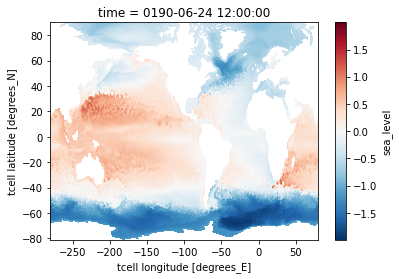

In [38]:
sl_arr = rechunked.sea_level
sl_arr.isel(time=2000).plot()

In [47]:
# var at_time - changes which time we are looking at for the plots below
at_time = 400

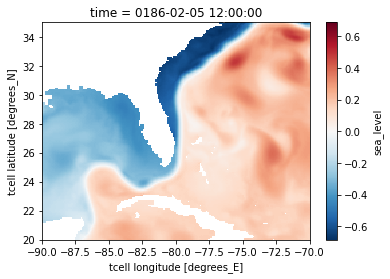

In [48]:
#Approximation of Florida/Keys/Cuba @ time
florida_approx = rechunked.sea_level.sel(xt_ocean=slice(-90,-70), yt_ocean=slice(20,35))
florida_approx.isel(time= at_time).plot()

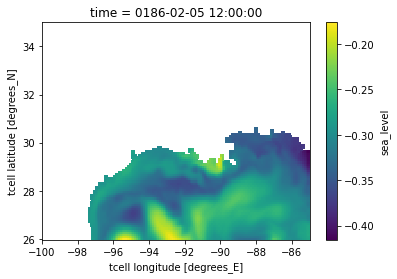

In [49]:
#Approximation of Houston/NOLA @time 
nola_approx = rechunked.sea_level.sel(xt_ocean=slice(-100,-85), yt_ocean=slice(26,35))
nola_approx.isel(time= at_time).plot()

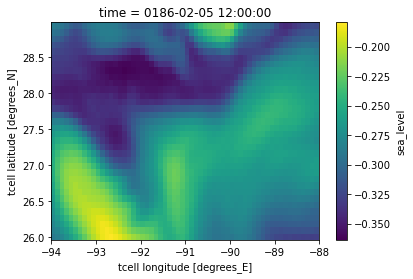

In [53]:
nola_closer = rechunked.sea_level.sel(xt_ocean=slice(-94,-88), yt_ocean=slice(26,29))
nola_closer.isel(time= at_time).plot()

<xarray.DataArray 'sea_level' (time: 5844)>
dask.array<getitem, shape=(5844,), dtype=float32, chunksize=(5844,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0185-01-01 12:00:00 ... 0200-12-31 12:00:00
    xt_ocean  float64 -89.95
    yt_ocean  float64 29.02
<xarray.DataArray 'sea_level' (time: 5844)>
array([-0.1313824 , -0.12658106, -0.14812852, ..., -0.15065938,
       -0.16740538, -0.12203974], dtype=float32)
Coordinates:
  * time     (time) object 0185-01-01 12:00:00 ... 0200-12-31 12:00:00


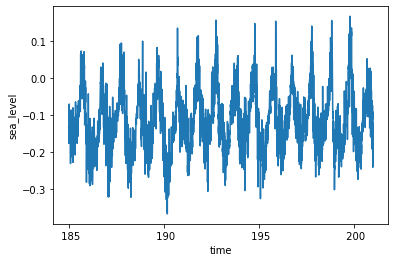

In [55]:
# NOLA coords
coords = (29, -90)

# Grab the approximate chunk for provided coords
area_approx = rechunked.sea_level.sel(xt_ocean=coords[1], yt_ocean=coords[0], method="nearest")
print(area_approx)

# Set up the DataArray with data as the sea level of the approximate area, and time as it's dimension
coords_dict = {'time': sea_level_picontrol['time']}
area_sea_level = xr.DataArray(area_approx, dims=('time'), coords=coords_dict)

print(area_sea_level)

# Note: I did not remove seasonal cycles
area_sea_level.plot()

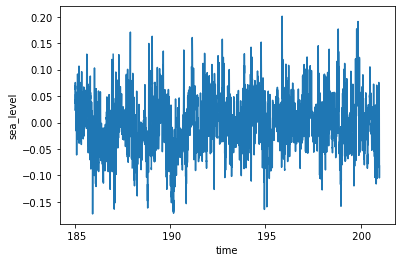

In [151]:
# Remove seasonal cycle
seasonal_cycle = area_sea_level.groupby('time.dayofyear').mean().compute();
seasonal_cycle = seasonal_cycle.rolling(dayofyear=10, center=True).mean().compute()
sla = area_sea_level.groupby("time.dayofyear") - seasonal_cycle
sla = sla.compute()

sla.plot()
# sla

In [155]:

# Function to remove the seasonal cycle
def remove_seasonal_cycle(dsl):
    '''Given a timeseries of daily dynamic sea level (dsl), returns the sea level anomaly (sla).
    A 10-day rolling average is used to smoothen the computed seasonal cycle.'''
    seasonal_cycle = dsl.groupby('time.dayofyear').mean().compute()
    seasonal_cycle = seasonal_cycle.rolling(dayofyear=10, center=True).mean().compute()
    sla = dsl.groupby('time.dayofyear') - seasonal_cycle
    sla = sla.compute()
    return sla

# Create a function which returns the p-percentile for each year in the record.
def return_percentiles(timeseries, q):
    '''Given an xarray timeseries and percentile q, returns an xarray dataarray 
    of the p-percentile of the timeseries for each year.
    
    For instance, given a sea level timeseries of ranging from 1991 to 2000 and q=50,
    this function returns the median sea level over each of the ten years in the record.'''
    
    years = np.unique(timeseries.time.dt.year)
    
    # Initialize xarray DataArray of percentiles
    percentiles = xr.DataArray(np.zeros(len(years)), dims=('year'), coords={'year': years})
    
    for year in years:
        # Select timeseries of particular year
        string_year = '0' + str(int(year))
        current_timeseries = timeseries.sel(time = string_year)
        
        # Determine percentile of timeseries
        percentile = np.nanpercentile(current_timeseries, q)
        
        # Add to DataArray
        percentiles.loc[{'year': year}] = percentile
        
    return percentiles

def plot_median_and_extremes(timeseries, title='', show_regression=True):
    fig, ax = plt.subplots()
    median = return_percentiles(timeseries, 50)
    extremes = return_percentiles(timeseries, 99)
    median.plot(ax=ax, linestyle='', marker='.', color='k', label='median')
    extremes.plot(ax=ax, linestyle='', marker='.', color='r', label='99th percentile')
    ax.set_ylabel('Sea level [meters]')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1,1))
    
    if show_regression:
        # Regression for median
        reg_1 = linear_model.LinearRegression()
        X_median = np.array(median['year']).reshape(-1,1) # Need to reshape into 2D array of shape (num_features, 1)
        Y_median = median.data
        reg_1.fit(X_median, Y_median)
        reg_1.predict(X_median)
        ax.plot(X_median, reg_1.predict(X_median), linestyle='-', color='k')
        
        # Regression for extremes
        reg_2 = linear_model.LinearRegression()
        X_extreme = np.array(extremes['year']).reshape(-1,1)
        Y_extreme = extremes.data
        reg_2.fit(X_extreme, Y_extreme)
        reg_2.predict(X_extreme)
        ax.plot(X_median, reg_2.predict(X_extreme), linestyle='-', color='r')
        
        median_slope = reg_1.coef_[0] * 1000 # Units: mm/year
        extremes_slope = reg_2.coef_[0] * 1000
        
        print('Slope of medians: ', median_slope, 'mm/year')
        print('Slope of extremes: ', extremes_slope, 'mm/year')
        
        print('RMSE medians: ', mean_squared_error(Y_median, reg_1.predict(X_median), squared=False), 'meters')
        print('RMSE extremes: ', mean_squared_error(Y_extreme, reg_1.predict(X_extreme), squared=False), 'meters')

Slope of medians:  1.2221531750743877 mm/year
Slope of extremes:  1.3107709954766655 mm/year
RMSE medians:  0.01663015376544362 meters
RMSE extremes:  0.11788198716712892 meters


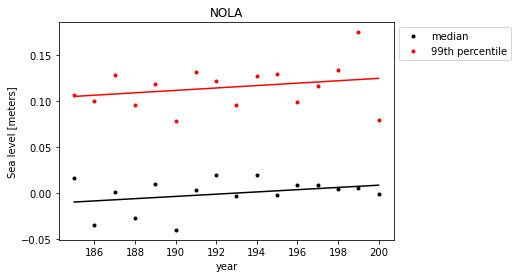

In [156]:
plot_median_and_extremes(sla, 'NOLA')